# Cлои нормализации.

 

Самая популярная версия слоя нормализации - слой нормализации "по батчу" (batch-norm слой).

Рассмотрим его работу в наиболее простом случае, когда на вход подается батч из одномерных векторов:

* На вход подается батч одномерных векторов:

> ${x_i}^{(j)}$

где j индекс вектора внутри батча, i - номер компоненты.

Для текущего батча:

*  По каждой компоненте входа вычисляются мат.ожидание и дисперсия:




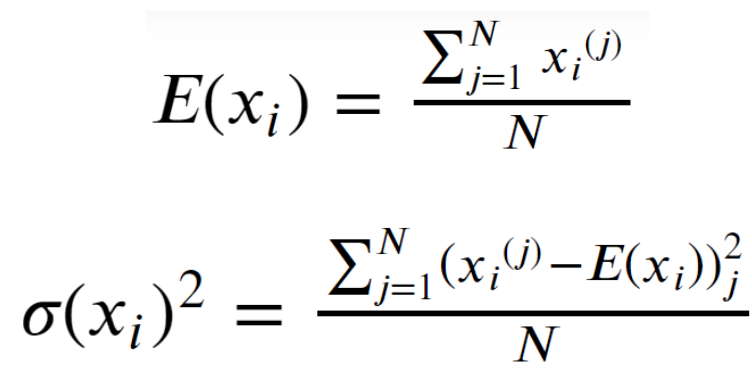



* Вход нормируется по формуле: 



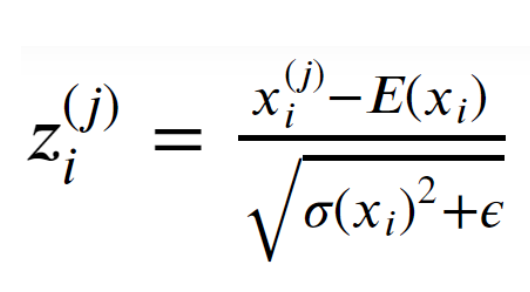

Эпсилон необходим для случая нулевой дисперсии.

* Нормированный вход преобразуется следующим образом:



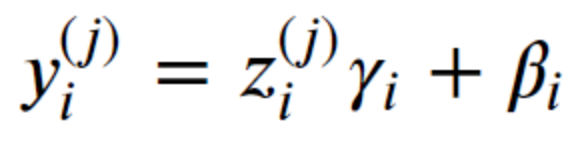

Где Гамма и Бета - обучаемые параметры слоя. Обратите внимание, Гамма и Бета - вектора такой же длины, как инстансы входа.

Их можно фиксировать, например, простейший случай - Бета принимается равным нулевому вектору, Гамма - вектору из единиц. 

Если же взять Гамму равным знаменателю дроби из формулы для Z, а Бету равным мат.ожиданию, то слой вернет входной тензор без изменений. То есть, слой будет эквивалентен тождественной функции.

 

Таким образом, параметры Бета и Гамма позволяют не терять входящию в слой информацию, и одновременно с этим, батч-норм слой нормализует вход. Последнее ускоряет сходимость параметров сети, а в некоторых случаях без нормализации добиться сходимости сети крайне сложно.

 

Итоговая формула преобразования входа: 



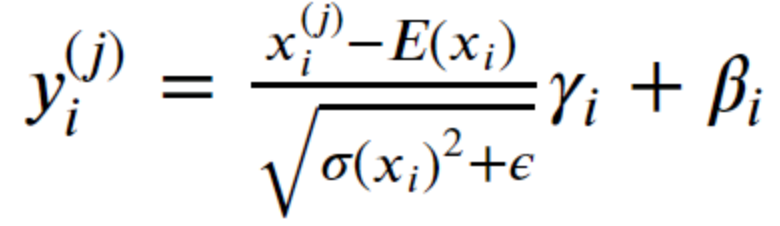




* Вначале реализуем train-этап батч-нормализации для батча из одномерных векторов с нулевым Бета и единичным Гамма.
* Затем добавим возможность задания параметров Бета и Гамма.
* После этого добавим eval-этап использования слоя.
* И последним шагом по батч-нормализации реализуем train-этап слоя батч-нормализации для батча из многоканальных двумерных тензоров с нулевым Бета и единичным Гамма.



После батч-нормализации другие виды нормализации.

Реализовать функцию батч-нормализации без использования стандартной функции со следующими упрощениями:

* Параметр Бета принимается равным 0.
* Параметр Гамма принимается равным 1.
* Функция должна корректно работать только на этапе обучения.
* Вход имеет размерность число элементов в батче * длина каждого инстанса.

In [ ]:
import numpy as np
import torch
import torch.nn as nn

def custom_batch_norm1d(input_tensor, eps):
  gamma = torch.ones(input_tensor.shape[1])
  beta = torch.zeros(input_tensor.shape[1])
  expected_value = torch.mean(input_tensor, 0)
  dispersion = torch.var(input_tensor, 0, unbiased=False)
  normed_tensor = (input_tensor - expected_value) / (torch.sqrt(dispersion + eps)) # Напишите в этом месте нормирование входного тензора
  normed_tensor = normed_tensor * gamma + beta
  return normed_tensor


input_tensor = torch.Tensor([[0.0, 0, 1, 0, 2], [0, 1, 1, 0, 10]])
batch_norm = nn.BatchNorm1d(input_tensor.shape[1], affine=False)

all_correct = True
for eps_power in range(10):
    eps = np.power(10., -eps_power)
    batch_norm.eps = eps
    batch_norm_out = batch_norm(input_tensor)
    custom_batch_norm_out = custom_batch_norm1d(input_tensor, eps)

    all_correct &= torch.allclose(batch_norm_out, custom_batch_norm_out)
    all_correct &= batch_norm_out.shape == custom_batch_norm_out.shape
print(all_correct)

True


Добавим возможность задавать параметры Бета и Гамма.

На данном шаге вам требуется реализовать функцию батч-нормализации без использования стандартной функции со следующими упрощениями:

* Функция должна корректно работать только на этапе обучения.
* Вход имеет размерность число элементов в батче * длина каждого инстанса.

In [ ]:
import torch
import torch.nn as nn

input_size = 7
batch_size = 5
input_tensor = torch.randn(batch_size, input_size, dtype=torch.float)

eps = 1e-3

def custom_batch_norm1d(input_tensor, weight, bias, eps):
  expected_value = torch.mean(input_tensor, 0)
  dispersion = torch.var(input_tensor, 0, unbiased=False)
  normed_tensor = (input_tensor - expected_value) / (torch.sqrt(dispersion + eps)) # Напишите в этом месте нормирование входного тензора
  normed_tensor = normed_tensor * weight + bias
  return normed_tensor

batch_norm = nn.BatchNorm1d(input_size, eps=eps)
batch_norm.bias.data = torch.randn(input_size, dtype=torch.float)
batch_norm.weight.data = torch.randn(input_size, dtype=torch.float)
batch_norm_out = batch_norm(input_tensor)
custom_batch_norm_out = custom_batch_norm1d(input_tensor, batch_norm.weight.data, batch_norm.bias.data, eps)
print(torch.allclose(batch_norm_out, custom_batch_norm_out) \
      and batch_norm_out.shape == custom_batch_norm_out.shape)

True


Избавимся еще от одного упрощения - реализуем работу слоя батч-нормализации на этапе предсказания.

На этом этапе вместо статистик по батчу будем использовать экспоненциально сглаженные статистики из истории обучения слоя.

В данном шаге вам требуется реализовать полноценный класс батч-нормализации без использования стандартной функции, принимающий на вход двумерный тензор. Осторожно, расчёт дисперсии ведётся по смещенной выборке, а расчет скользящего среднего по несмещенной.

In [ ]:
import torch
import torch.nn as nn


input_size = 3
batch_size = 5
eps = 1e-1

class CustomBatchNorm1d:
    def __init__(self, weight, bias, eps, momentum):
        # Реализуйте в этом месте конструктор.
        self.weight = weight
        self.bias = bias
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # EMA в нулевой точке, где EMA(f_t) = (1 - momentum) * f_t + momentum * EMA(f_{t-1}):
        self.running_mean = 0
        self.running_var = 1

    def __call__(self, input_tensor):
    # Напишите в этом месте нормирование входного тензора
        # Мат. ожидание
        expected_value = torch.mean(input_tensor, 0)
        
        # Дисперсия
        dispersion = torch.var(input_tensor, 0, unbiased=False)
        
        # unbiased=True - расчет дисперсии по смещенной выборке (коррекция Бесселя), т.е. делим на N-1, а не на N
        dispersion_unb = torch.var(input_tensor, 0, unbiased=True)
        
        # Режим тренировки сети (применяем среднее значение по батчу):
        if self.training:
          # EMA - экспоненциальное скользящее среднее:
          self.running_var = (1 - self.momentum) * dispersion_unb + self.momentum * self.running_var
          self.running_mean = (1 - self.momentum) * expected_value + self.momentum * self.running_mean

          # Нормирование тензора:
          normed_tensor = (input_tensor - expected_value) / (torch.sqrt(dispersion + self.eps))* self.weight + self.bias

        # Режим предикта (применяем накопленные за время тренировки скользящие средние):
        else:
          normed_tensor = (input_tensor - self.running_mean) / (torch.sqrt(self.running_var + self.eps))* self.weight + self.bias
        return normed_tensor

    def eval(self):
        # В этом методе реализуйте переключение в режим предикта.
        self.training = False

batch_norm = nn.BatchNorm1d(input_size, eps=eps)
batch_norm.bias.data = torch.randn(input_size, dtype=torch.float)
batch_norm.weight.data = torch.randn(input_size, dtype=torch.float)
batch_norm.momentum = 0.5

custom_batch_norm1d = CustomBatchNorm1d(batch_norm.weight.data, batch_norm.bias.data, eps, batch_norm.momentum)

all_correct = True

for i in range(8):
    torch_input = torch.randn(batch_size, input_size, dtype=torch.float)
    norm_output = batch_norm(torch_input)
    custom_output = custom_batch_norm1d(torch_input)
    all_correct &= torch.allclose(norm_output, custom_output, atol=1e-04) \
        and norm_output.shape == custom_output.shape

batch_norm.eval()
custom_batch_norm1d.eval()

for i in range(8):
    torch_input = torch.randn(batch_size, input_size, dtype=torch.float)
    norm_output = batch_norm(torch_input)
    custom_output = custom_batch_norm1d(torch_input)
    all_correct &= torch.allclose(norm_output, custom_output, atol=1e-04) \
        and norm_output.shape == custom_output.shape
print(all_correct)

True



Слой батч-нормализации существует для входа любой размерности.

В данном шаге рассмотрим его для входа из многоканальных двумерных тензоров, например, изображений.

Если вытянуть каждый канал картинки в вектор, то вход будет трехмерным:

* количество картинок в батче
* число каналов в каждой картинке
* число пикселей в картинке

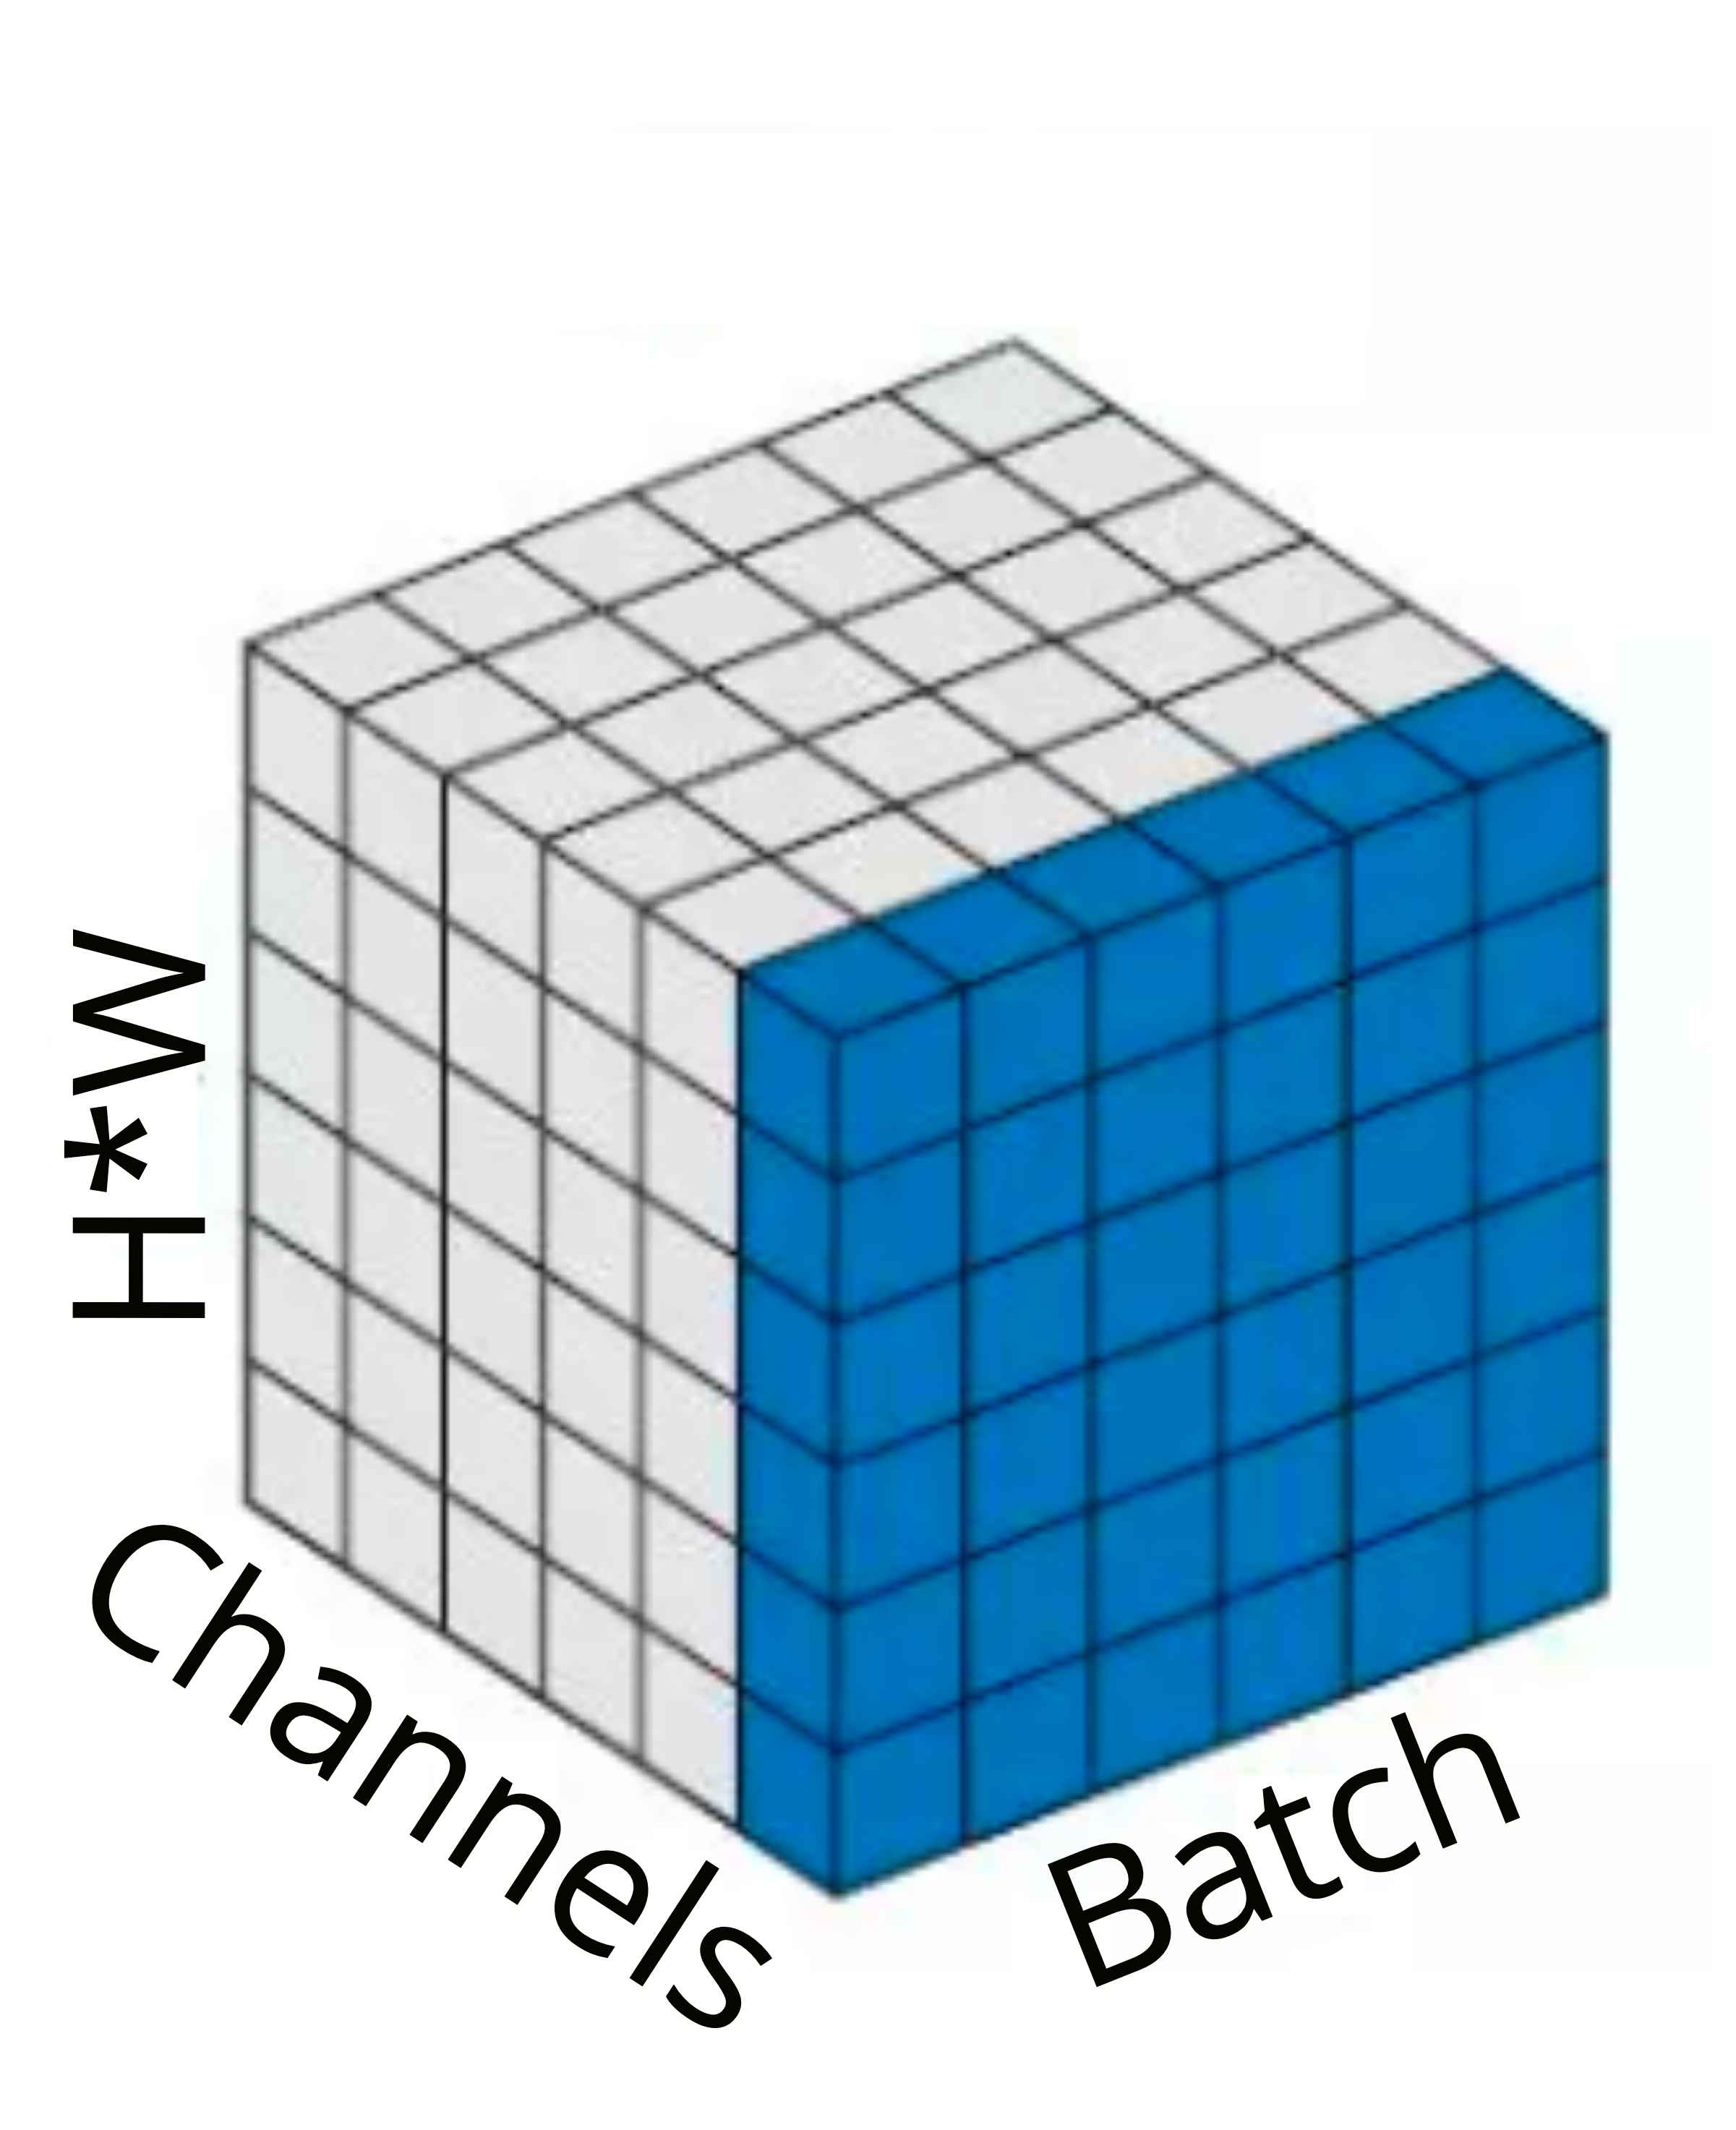

Процесс нормализации:

* Вход разбивается на срезы, параллельные синей части. То есть, каждый срез - это все пиксели всех изображений по одному из каналов.
* Для каждого среза считаются мат. ожидание и дисперсия.
* Каждый срез нормализуется независимо.
 

На данном шаге вам предлагается реализовать батч-норм слой для четырехмерного входа (например, батч из многоканальных двумерных картинок) без использования стандартной реализации со следующими упрощениями:

* Параметр Бета = 0.
* Параметр Гамма = 1.
* Функция должна корректно работать только на этапе обучения.

In [ ]:
import torch
import torch.nn as nn

eps = 1e-3

input_channels = 3
batch_size = 3
height = 10
width = 10

batch_norm_2d = nn.BatchNorm2d(input_channels, affine=False, eps=eps)

input_tensor = torch.randn(batch_size, input_channels, height, width, dtype=torch.float)


def custom_batch_norm2d(input_tensor, eps):
  # Напишите в этом методе нормирование тензора.
    # Считаем мат.ожидание для элементов на одних позициях в разных каналах
    # keepdim=True чтобы тензор сохранил наличие второй размерности: [3,1,10,10] вместо [3,3,10,10] и не сжимался по канальному измерению
    expected_value = torch.mean(input_tensor, dim=(0, 2, 3), keepdim=True)
    dispersion = torch.var(input_tensor, dim=(0, 2, 3), unbiased=False, keepdim=True)
    
    # # var не работает в старых версиях PyTorch, можно вручную расписать формулу:
    # dispersion = (input_tensor - expected_value).pow(2).mean(dim=(0, 2, 3), keepdim=True)

    normed_tensor = (input_tensor - expected_value) / torch.sqrt(dispersion + eps)
    return normed_tensor


norm_output = batch_norm_2d(input_tensor)
custom_output = custom_batch_norm2d(input_tensor, eps)
print(torch.allclose(norm_output, custom_output) and norm_output.shape == custom_output.shape)

True


Для упрощения остановимся на случае трехмерного тензора на входе слоя, если же размерность входа больше трех, то вытянем все размерности кроме первых двух в одну размерность.

Бывает нормировка не только по батчу, но и по другим измерениям.


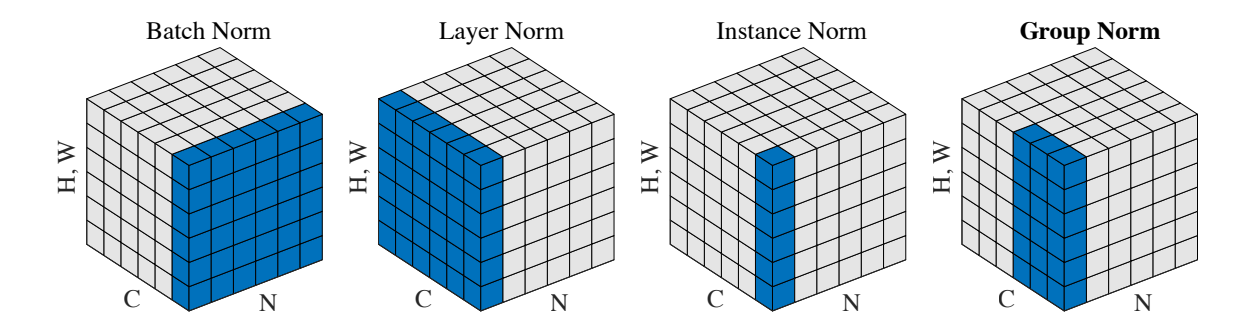

Где:

* C - число каналов на входе.
* N - размер батча.
* H, W - размерность по последней (третьей) размерности входа.
 

На изображении можно увидеть следующие виды нормализации:

* По батчу.
* По каналу.
* По инстансу.
* По группе.


Идея, лежащая в основе слоя нормализации "по каналу", что сеть должна быть независимой от контраста исходного изображения.

Нормализация "по каналу" работает независимо по каждому изображению батча.



На этом шаге вам предлагается реализовать нормализацию "по каналу" без использования стандартного слоя со следующими упрощениями:

* Параметр Бета = 0.
* Параметр Гамма = 1.
* Требуется реализация только этапа обучения.
* Нормализация делается по всем размерностям входа, кроме нулевой.
* Обратите внимание, что размерность входа на данном шаге не фиксирована.

Уточним, что в слое нормализации "по каналу" статистики считаются по всем размерностям, кроме нулевой.

In [ ]:
import torch
import torch.nn as nn


eps = 1e-10


def custom_layer_norm(input_tensor, eps):
    normed_tensor = torch.zeros(input_tensor.shape)
    for i in range(input_tensor.shape[0]):
        expected_value = input_tensor[i,:].mean()
        dispersion = input_tensor[i,:].var(unbiased=False)
        normed_tensor[i,:] = (input_tensor[i,:] - expected_value) / torch.sqrt(dispersion + eps)
    return normed_tensor


all_correct = True
for dim_count in range(3, 9):
    input_tensor = torch.randn(*list(range(3, dim_count + 2)), dtype=torch.float)
    
    layer_norm = nn.LayerNorm(input_tensor.size()[1:], elementwise_affine=False, eps=eps)

    norm_output = layer_norm(input_tensor)
    custom_output = custom_layer_norm(input_tensor, eps)

    all_correct &= torch.allclose(norm_output, custom_output, 1e-2)
    all_correct &= norm_output.shape == custom_output.shape
print(all_correct)


True


Нормализация "по инстансу" была изначально разработана для задачи style transfer. Идея, лежащая в основе этого слоя, что сеть должна быть независимой от контраста отдельных каналов исходного изображения.

На этом шаге вам предлагается реализовать нормализацию "по инстансу" без использования стандартного слоя со следующими упрощениями:

* Параметр Бета = 0.
* Параметр Гамма = 1.
* На вход подается трехмерный тензор (размер батча, число каналов, длина каждого канала инстанса).
* Требуется реализация только этапа обучения.
В слое нормализации "по инстансу" статистики считаются по последней размерности (по каждому входному каналу каждого входного примера).

In [ ]:
import torch
import torch.nn as nn

eps = 1e-3

batch_size = 5
input_channels = 2
input_length = 30

instance_norm = nn.InstanceNorm1d(input_channels, affine=False, eps=eps)

input_tensor = torch.randn(batch_size, input_channels, input_length, dtype=torch.float)


def custom_instance_norm1d(input_tensor, eps):
    expected_value = torch.mean(input_tensor, dim=(2), keepdim=True)
    dispersion = torch.var(input_tensor, dim=(2), unbiased=False, keepdim=True)

    normed_tensor = (input_tensor - expected_value) / torch.sqrt(dispersion + eps)
    return normed_tensor


norm_output = instance_norm(input_tensor)
custom_output = custom_instance_norm1d(input_tensor, eps)
print(torch.allclose(norm_output, custom_output, atol=1e-06) and norm_output.shape == custom_output.shape)

True


Нормализация "по группе" - это обобщение нормализации "по каналу" и "по инстансу".

Каналы в изображении не являются полностью независимыми, поэтому возможность использования статистики соседних каналов является преимуществом нормализации "по группе" по сравнению с нормализацией "по инстансу".

В то же время, каналы изображения могут сильно отличатся, поэтому нормализация "по группе" является более гибкой, чем нормализация "по каналу".

На этом шаге вам предлагается реализовать нормализацию "по группе" без использования стандартного слоя со следующими упрощениями:

* Параметр Бета = 0.
* Параметр Гамма = 1.
* Требуется реализация только этапа обучения.
* На вход подается трехмерный тензор.
* Также слой принимает на вход число групп.

В слое нормализации "по группе" статистики считаются очень похоже на нормализацию "по каналу", только каналы разбиваются на группы.

In [109]:
import torch
import torch.nn as nn

channel_count = 6
eps = 1e-3
batch_size = 20
input_size = 2

input_tensor = torch.randn(batch_size, channel_count, input_size)


def custom_group_norm(input_tensor, groups, eps):
    
    batch, channel, hight = input_tensor.shape
    input_tensor = input_tensor.reshape(batch, groups, channel // groups, hight)
    
    expected_value = torch.mean(input_tensor, dim=[2, 3], keepdim=True)
    dispersion = torch.var(input_tensor, dim=[2, 3], unbiased=False, keepdim=True)
    normed_tensor = (input_tensor - expected_value) / torch.sqrt(dispersion + eps)
    
    normed_tensor = normed_tensor.reshape(batch, channel, hight)
    return normed_tensor


all_correct = True
for groups in [1, 2, 3, 6]:
    group_norm = nn.GroupNorm(groups, channel_count, eps=eps, affine=False)
    norm_output = group_norm(input_tensor)
    custom_output = custom_group_norm(input_tensor, groups, eps)
    all_correct &= torch.allclose(norm_output, custom_output, 1e-3)
    all_correct &= norm_output.shape == custom_output.shape
print(all_correct)

True
